In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  1000

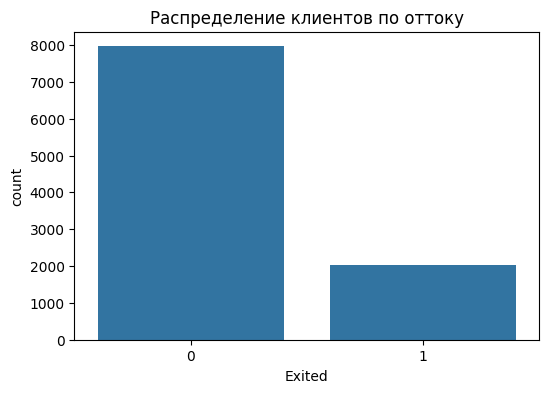

In [2]:
#Грузим датасет
df = pd.read_csv("Churn_Modelling.csv")
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Визуализация целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Exited')
plt.title("Распределение клиентов по оттоку")
plt.show()

In [3]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

X = df.drop('Exited', axis=1).values
y = df['Exited'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=50)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = X_train.shape[1]

In [ ]:
#Базовая модель
class BaseModel(nn.Module):
    def __init__(self, input_dim):
        super(BaseModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

base_model = BaseModel(input_dim)
criterion_base = nn.BCELoss()
optimizer_base = optim.Adam(base_model.parameters(), lr=0.001)

In [5]:
epochs_base = 100
base_train_losses, base_test_losses, base_accuracy_list = [], [], []

for epoch in range(epochs_base):
    base_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_base.zero_grad()
        outputs = base_model(inputs)
        loss = criterion_base(outputs, labels)
        loss.backward()
        optimizer_base.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    base_train_losses.append(train_loss)

    base_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = base_model(inputs)
            loss = criterion_base(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_loss = test_loss / len(test_loader.dataset)
    base_test_losses.append(test_loss)
    accuracy = 100 * correct / total
    base_accuracy_list.append(accuracy)

    print(f"[Базовая модель] Эпоха {epoch+1}/{epochs_base}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")


[Базовая модель] Эпоха 1/100, Train Loss: 0.5137, Test Loss: 0.4505, Accuracy: 80.05%
[Базовая модель] Эпоха 2/100, Train Loss: 0.4291, Test Loss: 0.4268, Accuracy: 81.60%
[Базовая модель] Эпоха 3/100, Train Loss: 0.4124, Test Loss: 0.4138, Accuracy: 82.20%
[Базовая модель] Эпоха 4/100, Train Loss: 0.3997, Test Loss: 0.4006, Accuracy: 82.80%
[Базовая модель] Эпоха 5/100, Train Loss: 0.3867, Test Loss: 0.3853, Accuracy: 83.45%
[Базовая модель] Эпоха 6/100, Train Loss: 0.3750, Test Loss: 0.3733, Accuracy: 84.20%
[Базовая модель] Эпоха 7/100, Train Loss: 0.3657, Test Loss: 0.3650, Accuracy: 84.80%
[Базовая модель] Эпоха 8/100, Train Loss: 0.3599, Test Loss: 0.3571, Accuracy: 84.90%
[Базовая модель] Эпоха 9/100, Train Loss: 0.3550, Test Loss: 0.3521, Accuracy: 85.25%
[Базовая модель] Эпоха 10/100, Train Loss: 0.3515, Test Loss: 0.3498, Accuracy: 85.25%
[Базовая модель] Эпоха 11/100, Train Loss: 0.3485, Test Loss: 0.3467, Accuracy: 85.25%
[Базовая модель] Эпоха 12/100, Train Loss: 0.3465, T

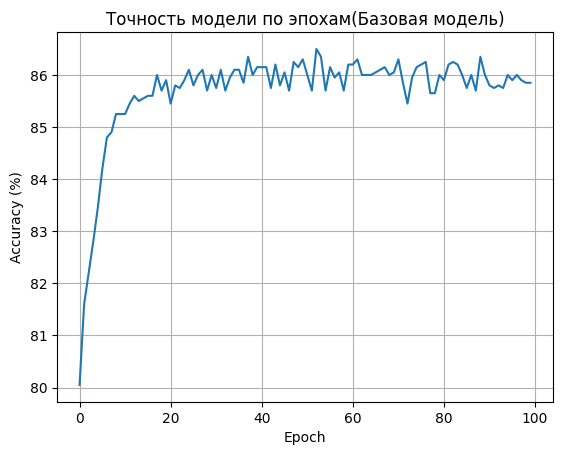

In [6]:
plt.plot(base_accuracy_list, label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Точность модели по эпохам(Базовая модель)")
plt.grid(True)
plt.show()

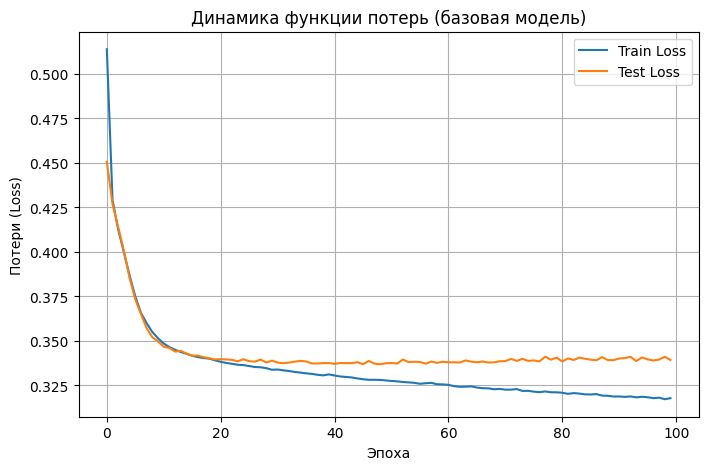

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(base_train_losses, label="Train Loss")
plt.plot(base_test_losses, label="Test Loss")
plt.xlabel("Эпоха")
plt.ylabel("Потери (Loss)")
plt.title("Динамика функции потерь (базовая модель)")
plt.legend()
plt.grid()
plt.show()

In [8]:
base_model.eval()
with torch.no_grad():
    y_probs_base = base_model(X_test_tensor).squeeze().numpy()
    y_pred_base = (y_probs_base >= 0.5).astype(int)

print("Базовая модель:")
print(classification_report(y_test, y_pred_base))
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("AUC-ROC:", roc_auc_score(y_test, y_probs_base))

fpr_base, tpr_base, _ = roc_curve(y_test, y_probs_base)
roc_auc_base = auc(fpr_base, tpr_base)

Базовая модель:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.71      0.52      0.60       407

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

Accuracy: 0.8585
AUC-ROC: 0.8612140646038953


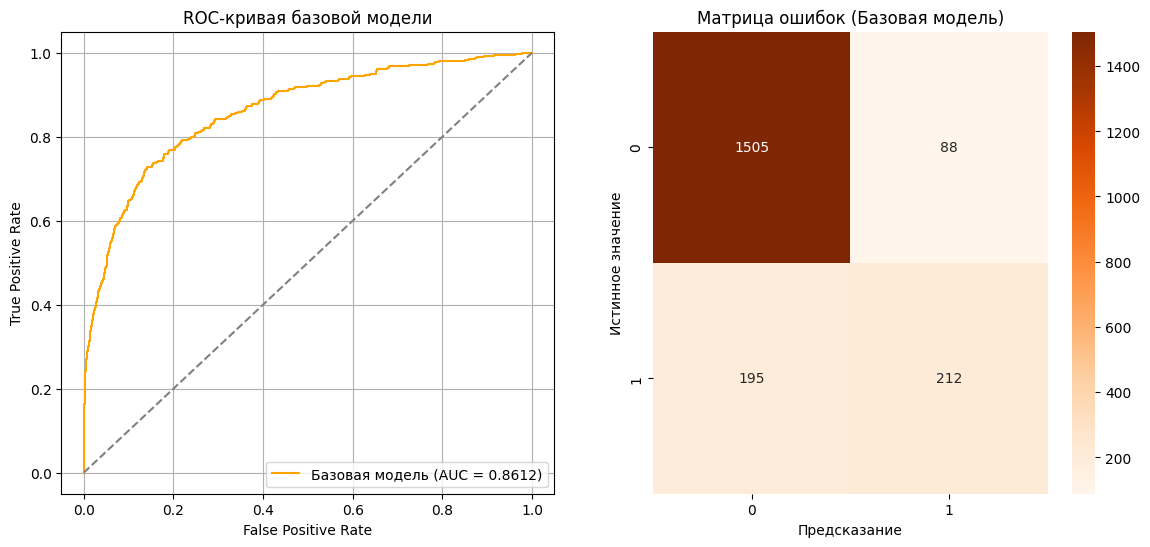

In [ ]:
#Базовая ROC-кривая
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_base, tpr_base, label=f"Базовая модель (AUC = {roc_auc_base:.4f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая базовой модели")
plt.legend(loc="lower right")
plt.grid()

#Матрица ошибок базовой модели
plt.subplot(1, 2, 2)
cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Oranges', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Матрица ошибок (Базовая модель)")
plt.xlabel("Предсказание")
plt.ylabel("Истинное значение")
plt.show()

In [10]:
#Ранняя остановка при отсутствии изменений в loss.
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
#Улучшенная модель
class ImprovedModel(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.drop3 = nn.Dropout(0.2)
        self.out = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.drop1(self.relu(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu(self.bn2(self.fc2(x))))
        x = self.drop3(self.relu(self.bn3(self.fc3(x))))
        return self.sigmoid(self.out(x))

improved_model = ImprovedModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.0015, weight_decay=0.0015)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15)

early_stopper = EarlyStopping(patience=10, delta=0.0001)
epochs = 300
train_losses, test_losses, accuracy_list = [], [], []

for epoch in range(epochs):
    improved_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = improved_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    improved_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = improved_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)

    scheduler.step(test_loss)

 
    print(f"[Улучшенная модель] Эпоха {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

    #Остановка
    early_stopper(test_loss)
    if early_stopper.early_stop:
        print(f"Ранняя остановка на эпохе {epoch+1}!")
        break 

[Улучшенная модель] Эпоха 1/300, Train Loss: 0.4841, Test Loss: 0.4306, Accuracy: 81.85%
[Улучшенная модель] Эпоха 2/300, Train Loss: 0.4306, Test Loss: 0.3924, Accuracy: 83.65%
[Улучшенная модель] Эпоха 3/300, Train Loss: 0.4104, Test Loss: 0.3706, Accuracy: 85.30%
[Улучшенная модель] Эпоха 4/300, Train Loss: 0.3990, Test Loss: 0.3569, Accuracy: 86.00%
[Улучшенная модель] Эпоха 5/300, Train Loss: 0.3894, Test Loss: 0.3474, Accuracy: 85.90%
[Улучшенная модель] Эпоха 6/300, Train Loss: 0.3851, Test Loss: 0.3431, Accuracy: 85.80%
[Улучшенная модель] Эпоха 7/300, Train Loss: 0.3772, Test Loss: 0.3409, Accuracy: 86.30%
[Улучшенная модель] Эпоха 8/300, Train Loss: 0.3727, Test Loss: 0.3395, Accuracy: 86.00%
[Улучшенная модель] Эпоха 9/300, Train Loss: 0.3705, Test Loss: 0.3385, Accuracy: 85.95%
[Улучшенная модель] Эпоха 10/300, Train Loss: 0.3710, Test Loss: 0.3397, Accuracy: 86.15%
[Улучшенная модель] Эпоха 11/300, Train Loss: 0.3673, Test Loss: 0.3382, Accuracy: 86.15%
[Улучшенная модель]

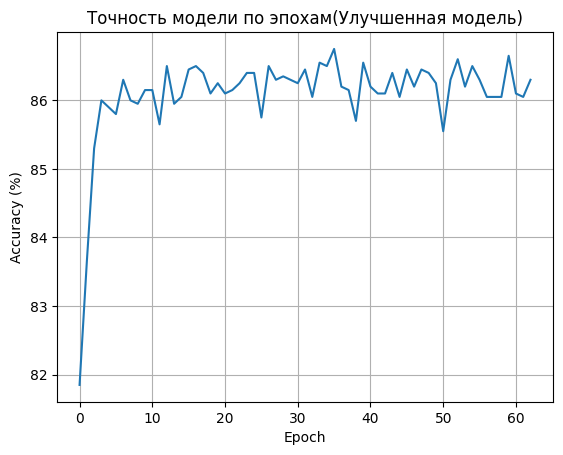

In [12]:
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Точность модели по эпохам(Улучшенная модель)")
plt.grid(True)
plt.show()


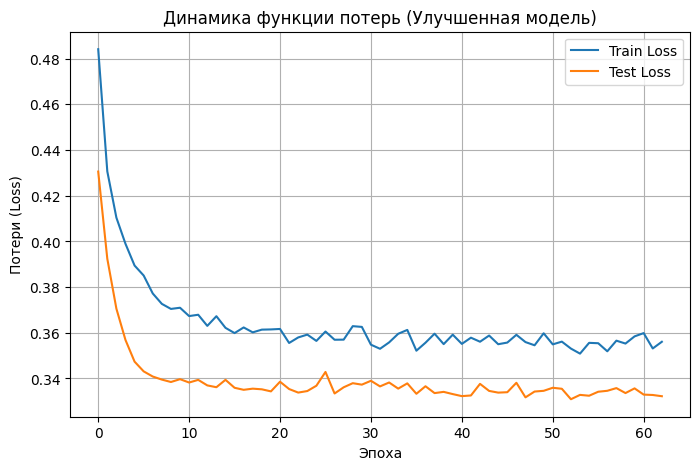

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Эпоха")
plt.ylabel("Потери (Loss)")
plt.title("Динамика функции потерь (Улучшенная модель)")
plt.legend()
plt.grid()
plt.show()

In [14]:
improved_model.eval()
with torch.no_grad():
    y_probs_improved = improved_model(X_test_tensor).squeeze().numpy()
    y_pred_improved = (y_probs_improved >= 0.5).astype(int)

print("\nУлучшенная модель:")
print(classification_report(y_test, y_pred_improved))
print("Accuracy:", accuracy_score(y_test, y_pred_improved))
print("AUC-ROC:", roc_auc_score(y_test, y_probs_improved))

fpr_improved, tpr_improved, _ = roc_curve(y_test, y_probs_improved)
roc_auc_improved = auc(fpr_improved, tpr_improved)



Улучшенная модель:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1593
           1       0.73      0.51      0.60       407

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

Accuracy: 0.863
AUC-ROC: 0.8669501550857484


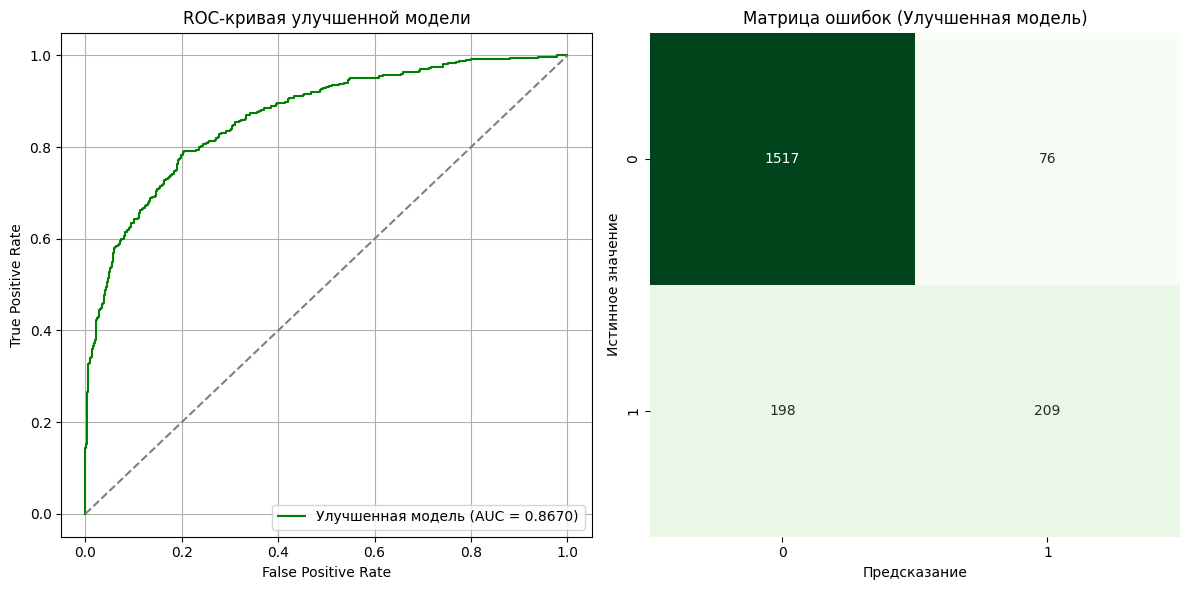

In [15]:
#ROC-кривая улучшенной модели
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_improved, tpr_improved, label=f"Улучшенная модель (AUC = {roc_auc_improved:.4f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая улучшенной модели")
plt.legend(loc="lower right")
plt.grid()

#Матрица ошибок улучшенной модели
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred_improved)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["0", "1"], yticklabels=["0", "1"], cbar=False)
plt.title("Матрица ошибок (Улучшенная модель)")
plt.xlabel("Предсказание")
plt.ylabel("Истинное значение")
plt.tight_layout()
plt.show()

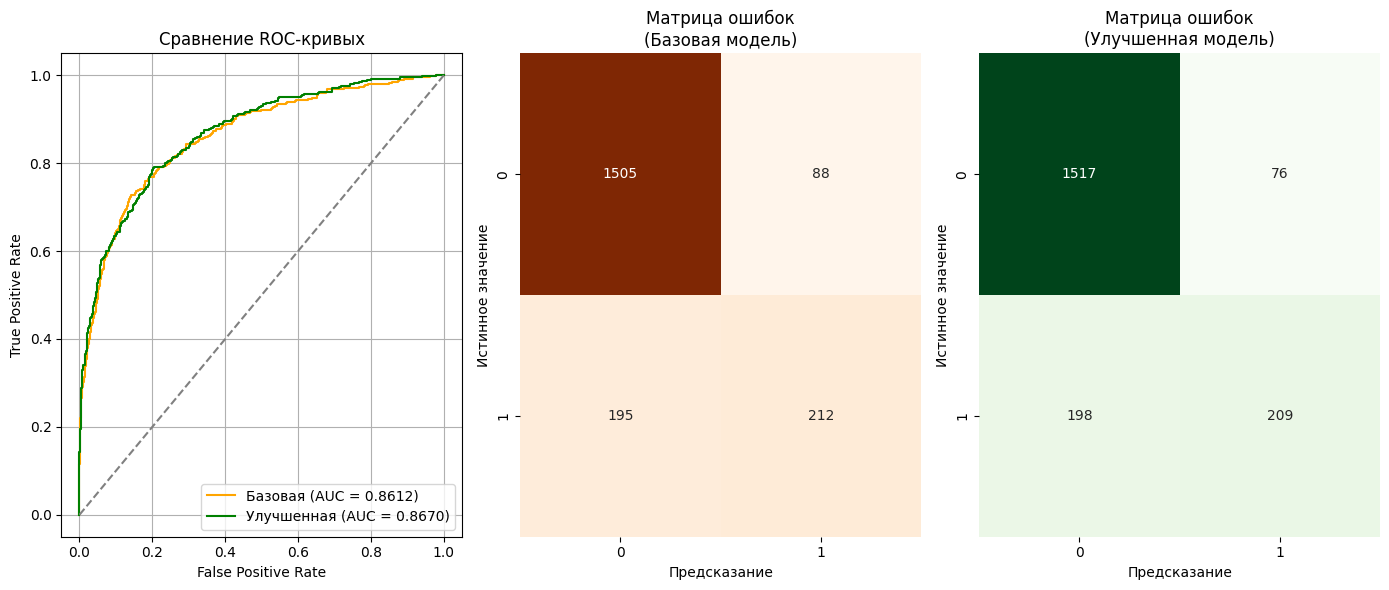

In [16]:

#Базовая и улучшенная ROC-кривая
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(fpr_base, tpr_base, label=f'Базовая (AUC = {roc_auc_base:.4f})', color='orange')
plt.plot(fpr_improved, tpr_improved, label=f'Улучшенная (AUC = {roc_auc_improved:.4f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Сравнение ROC-кривых")
plt.legend()
plt.grid()

#Базовая матрица
plt.subplot(1, 3, 2)
cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Oranges', xticklabels=["0", "1"], yticklabels=["0", "1"], cbar=False)
plt.title("Матрица ошибок\n(Базовая модель)")
plt.xlabel("Предсказание")
plt.ylabel("Истинное значение")

#Улучшенная матрица
plt.subplot(1, 3, 3)
cm_improved = confusion_matrix(y_test, y_pred_improved)
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Greens', xticklabels=["0", "1"], yticklabels=["0", "1"], cbar=False)
plt.title("Матрица ошибок\n(Улучшенная модель)")
plt.xlabel("Предсказание")
plt.ylabel("Истинное значение")
plt.tight_layout()
plt.show()

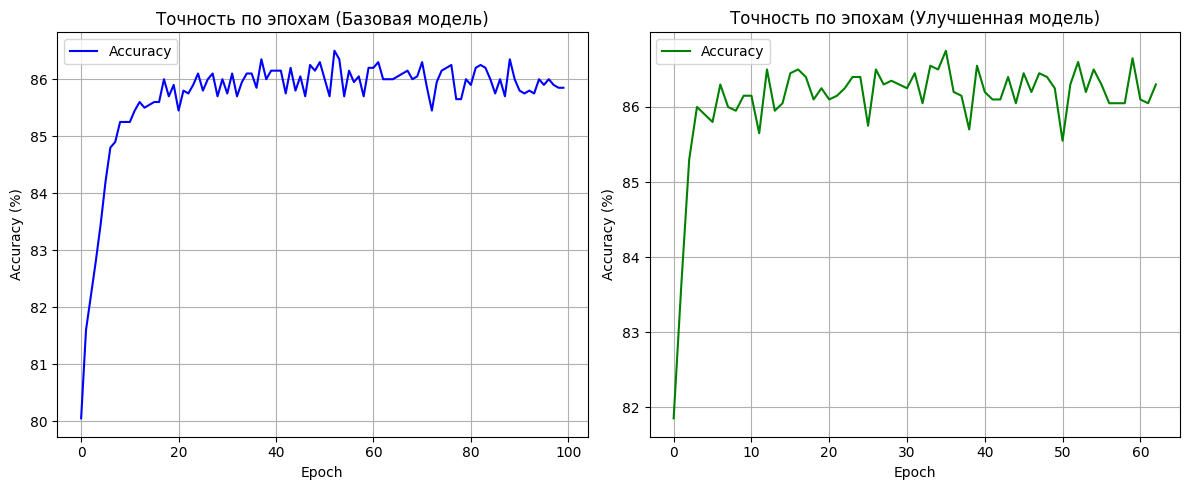

In [ ]:
plt.figure(figsize=(12, 5))

#Базовая модель
plt.subplot(1, 2, 1)
plt.plot(base_accuracy_list, label='Accuracy', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Точность по эпохам (Базовая модель)")
plt.legend()
plt.grid(True)

#Улучшенная модель
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Точность по эпохам (Улучшенная модель)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
print("Базовая модель:")
print(classification_report(y_test, y_pred_base))
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("AUC-ROC:", roc_auc_score(y_test, y_probs_base))

fpr_base, tpr_base, _ = roc_curve(y_test, y_probs_base)
roc_auc_base = auc(fpr_base, tpr_base)

print("\nУлучшенная модель:")
print(classification_report(y_test, y_pred_improved))
print("Accuracy:", accuracy_score(y_test, y_pred_improved))
print("AUC-ROC:", roc_auc_score(y_test, y_probs_improved))

fpr_improved, tpr_improved, _ = roc_curve(y_test, y_probs_improved)
roc_auc_improved = auc(fpr_improved, tpr_improved)

Базовая модель:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.71      0.52      0.60       407

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

Accuracy: 0.8585
AUC-ROC: 0.8612140646038953

Улучшенная модель:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1593
           1       0.73      0.51      0.60       407

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

Accuracy: 0.863
AUC-ROC: 0.8669501550857484
